# Section 5.2 — Bayesian inference computations

This notebook contains the code examples from [Section 5.2 Bayesian inference computations]() from the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn"t work
from plot_helpers import RCPARAMS
RCPARAMS.update({"figure.figsize": (5, 3)})   # good for screen
# RCPARAMS.update({"figure.figsize": (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# High-resolution please
%config InlineBackend.figure_format = "retina"

# Where to store figures
DESTDIR = "figures/bayesian/computations"

<Figure size 640x480 with 0 Axes>

In [3]:
# set random seed for repeatability
np.random.seed(42)
#######################################################

## Example 1: estimating the probability of a biased coin

In [4]:
from scipy.stats import bernoulli
tosses = bernoulli(0.7).rvs(20)

In [5]:
# Declare a model in PyMC

import pymc as pm

with pm.Model() as model:
    # Specify the prior distribution of unknown parameter
    p = pm.Beta("p", alpha=1, beta=1)

    # Specify the likelihood distribution and condition on the observed data
    y_obs = pm.Binomial("y_obs", n=1, p=p, observed=tosses)

    # Sample from the posterior distribution
    idata = pm.sample(1000)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


In [6]:
import arviz as az
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.688,0.092,0.522,0.861,0.002,0.002,1601.0,2528.0,1.0


In [7]:
pred_dists = (pm.sample_prior_predictive(1000, model).prior_predictive["y_obs"].values,
              pm.sample_posterior_predictive(idata, model).posterior_predictive["y_obs"].values)

Sampling: [p, y_obs]
Sampling: [y_obs]


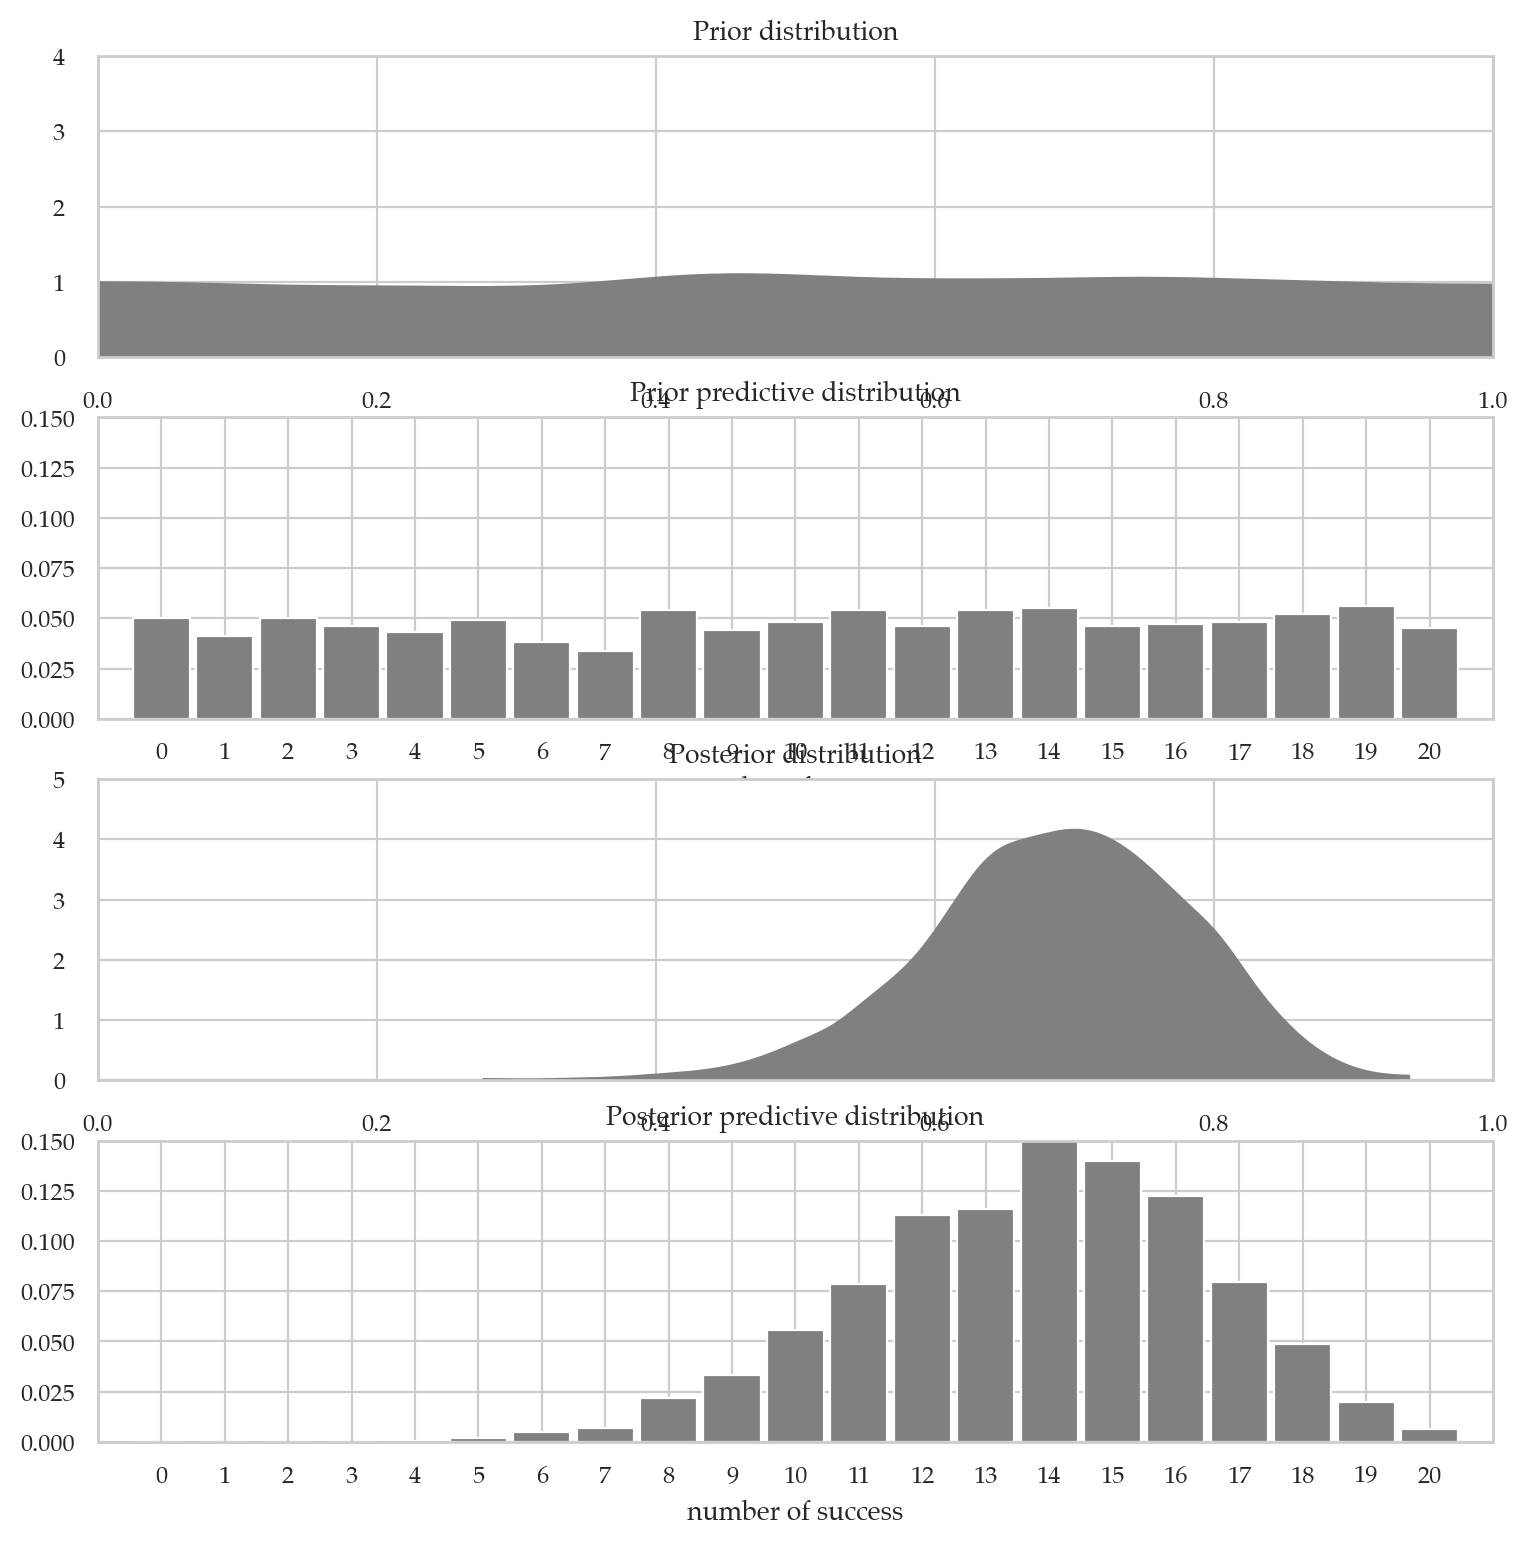

In [8]:
fig, axes = plt.subplots(4, 1, figsize=(9, 9))

for idx, n_d, dist in zip((1, 3), ("Prior", "Posterior"), pred_dists):
    az.plot_dist(dist.sum(-1), 
                 hist_kwargs={"color":"0.5", "bins":range(0, 22)},
                 ax=axes[idx])
    axes[idx].set_title(f"{n_d} predictive distribution", fontweight='bold')
    axes[idx].set_xlim(-1, 21)
    axes[idx].set_ylim(0, 0.15)
    axes[idx].set_xlabel("number of success")

az.plot_dist(pm.draw(p, 1000),
             plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1}, ax=axes[0])
axes[0].set_title("Prior distribution", fontweight='bold')
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 4)
axes[0].tick_params(axis='both', pad=7)
axes[0].set_xlabel("p")

az.plot_dist(idata.posterior["p"],
             plot_kwargs={"color":"0.5"},
             fill_kwargs={'alpha':1},
             ax=axes[2])
axes[2].set_title("Posterior distribution", fontweight='bold')
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 5)
axes[2].tick_params(axis='both', pad=7)
axes[2].set_xlabel("p");


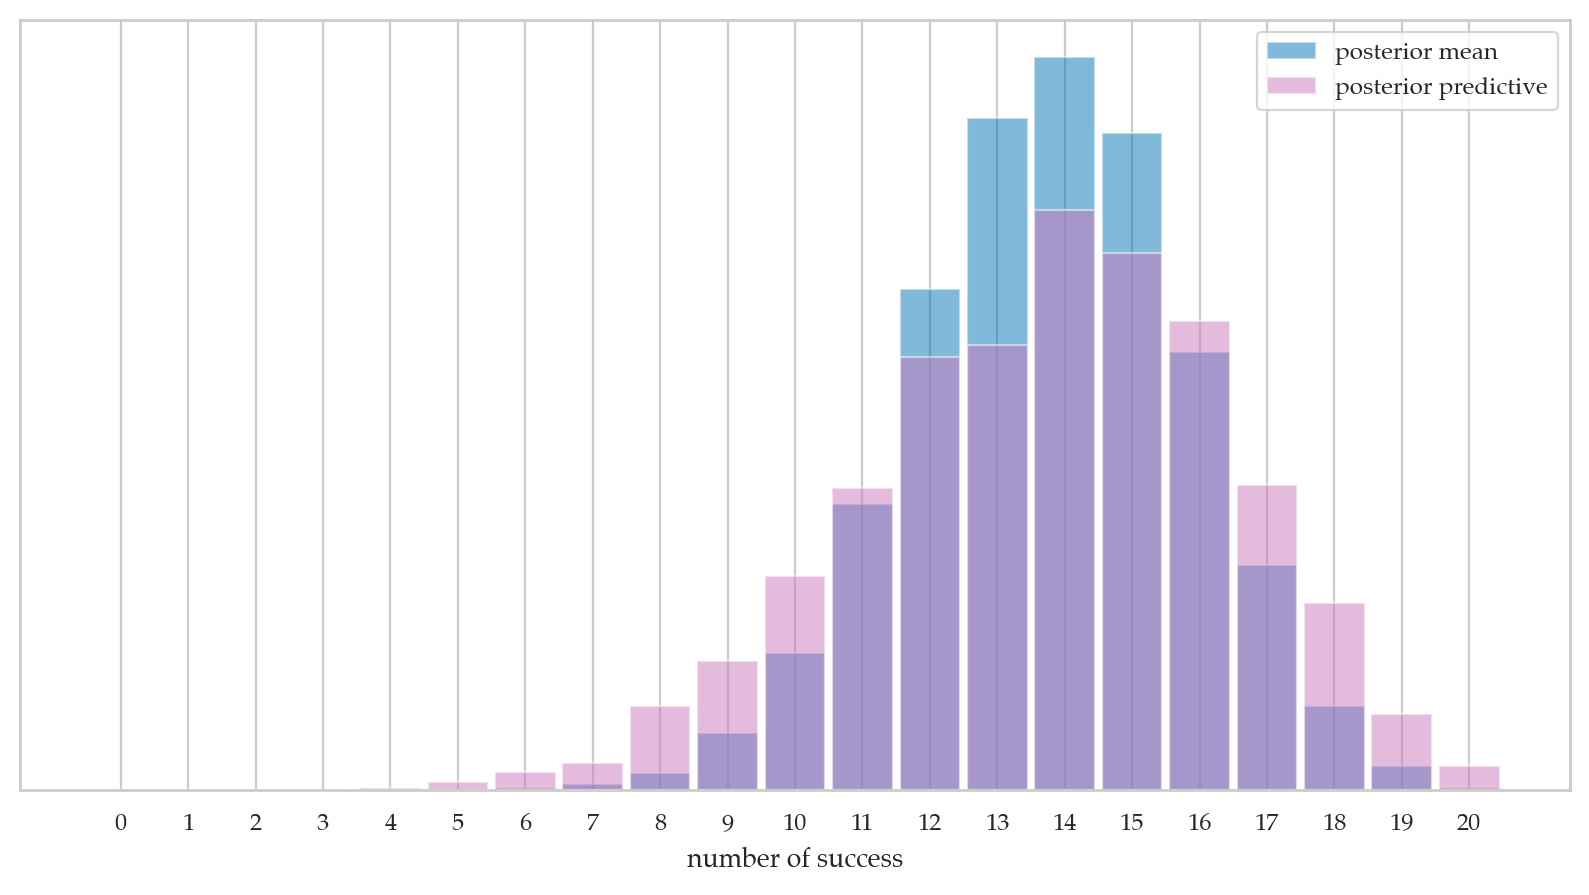

In [9]:
from scipy.stats import binom

predictions = (binom(n=1, p=idata.posterior["p"].mean()).rvs((4000, len(tosses))),
               pred_dists[1])

for d, c, l in zip(predictions, ("C0", "C4"), ("posterior mean", "posterior predictive")):
    ax = az.plot_dist(d.sum(-1),
                      label=l,
                      figsize=(10, 5),
                      hist_kwargs={"alpha": 0.5, "color":c, "bins":range(0, 22)})
    ax.set_yticks([])
    ax.set_xlabel("number of success")

## Discussion

### MCMC diagnostic plots

There are several Arviz plots we can use to check if the Markov Chain Monte Carlo chains were sampling from the posterior as expected, or ...

In [10]:
# az.plot_trace(idata);
# az.plot_trace(idata, kind="rank_bars");
# az.plot_trace(idata, kind="rank_vlines");

# plot_cap ~= partial regression plots?
# e.g. plot_cap(model_2, fitted_2, "weight", ax=ax);

### Choice of priors

Different priors lead to different posteriors.

See `Code 1.8 and Figure 1.7` in
[chp_01.ipynb](./explorations/PyBayesianBookCode/notebooks_updated/chp_01.ipynb)

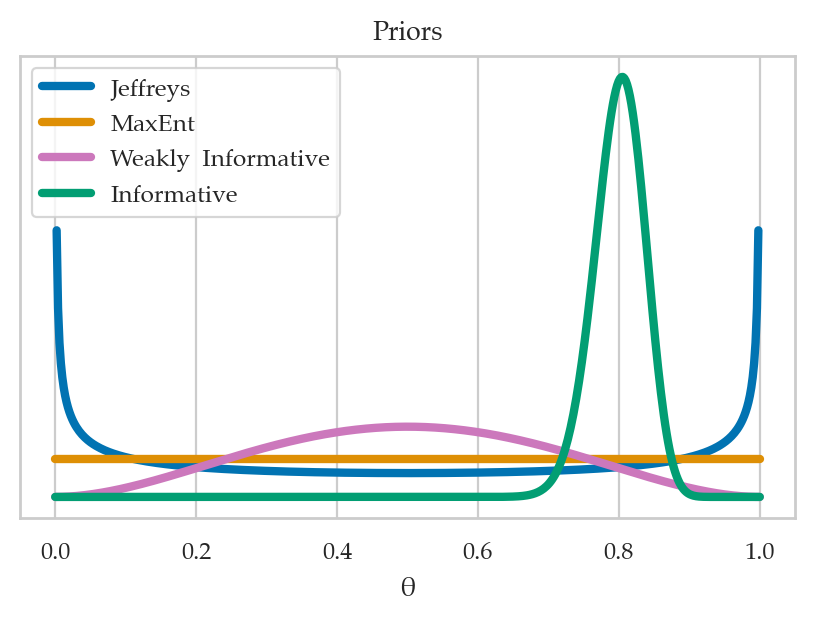

In [11]:
from scipy.stats import beta

x = np.linspace(0, 1, 500)
params = [(0.5, 0.5), (1, 1), (3,3), (100, 25)]

labels = ["Jeffreys", "MaxEnt", "Weakly  Informative",
          "Informative"]

_, ax = plt.subplots()
for (α, β), label, c in zip(params, labels, (0, 1, 4, 2)):
    pdf = beta.pdf(x, α, β)
    ax.plot(x, pdf, label=f"{label}", c=f"C{c}", lw=3)
    ax.set(yticks=[], xlabel="θ", title="Priors")
    ax.legend()
# plt.savefig("img/chp01/prior_informativeness_spectrum.png")

### Bayesian workflow

See also [chp_09.ipynb](./explorations/PyBayesianBookCode/notebooks_updated/chp_09.ipynb)